In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rka-ensemble-learning-challenge/sample_submission.csv
/kaggle/input/rka-ensemble-learning-challenge/train.csv
/kaggle/input/rka-ensemble-learning-challenge/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [3]:
df = pd.read_csv('/kaggle/input/rka-ensemble-learning-challenge/train.csv')
df_test = pd.read_csv('/kaggle/input/rka-ensemble-learning-challenge/test.csv')

In [4]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,28687,29.0,services,single,secondary,no,-205.0,no,no,cellular,30.0,jan,194.0,1.0,-1.0,0.0,unknown,0
1,9305,53.0,blue-collar,married,primary,no,0.0,yes,no,unknown,5.0,jun,285.0,2.0,-1.0,0.0,unknown,0
2,41426,55.0,management,married,NaN,no,2587.0,no,no,cellular,4.0,sep,328.0,2.0,94.0,2.0,success,1
3,44804,30.0,technician,single,tertiary,no,0.0,no,no,cellular,15.0,sep,214.0,2.0,-1.0,0.0,unknown,0
4,5879,30.0,unemployed,married,secondary,no,529.0,yes,yes,unknown,26.0,may,NaN,3.0,-1.0,0.0,unknown,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         36168 non-null  int64  
 1   age        35770 non-null  float64
 2   job        35734 non-null  object 
 3   marital    35698 non-null  object 
 4   education  35662 non-null  object 
 5   default    35625 non-null  object 
 6   balance    35589 non-null  float64
 7   housing    35553 non-null  object 
 8   loan       35517 non-null  object 
 9   contact    35481 non-null  object 
 10  day        35445 non-null  float64
 11  month      35408 non-null  object 
 12  duration   35372 non-null  float64
 13  campaign   35336 non-null  float64
 14  pdays      35300 non-null  float64
 15  previous   35264 non-null  float64
 16  poutcome   35228 non-null  object 
 17  y          36168 non-null  int64  
dtypes: float64(7), int64(2), object(9)
memory usage: 5.0+ MB


In [6]:
df.describe(include='all')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,36168.000000,35770.000000,35734,35698,35662,35625,35589.000000,35553,35517,35481,35445.000000,35408,35372.000000,35336.000000,35300.000000,35264.000000,35228,36168.000000
unique,NaN,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,NaN
top,NaN,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,NaN
freq,NaN,NaN,7720,21521,18340,34988,NaN,19734,29837,22923,NaN,10824,NaN,NaN,NaN,NaN,28792,NaN
mean,22547.433477,40.952390,NaN,NaN,NaN,NaN,1368.742168,NaN,NaN,NaN,15.801947,NaN,258.962484,2.753226,40.148725,0.579543,NaN,0.117010
std,13080.477704,10.612638,NaN,NaN,NaN,NaN,2980.607071,NaN,NaN,NaN,8.307924,NaN,259.005094,3.077914,99.755709,2.374508,NaN,0.321436
min,1.000000,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,0.000000
25%,11200.750000,33.000000,NaN,NaN,NaN,NaN,74.000000,NaN,NaN,NaN,8.000000,NaN,104.000000,1.000000,-1.000000,0.000000,NaN,0.000000
50%,22479.500000,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,0.000000
75%,33891.250000,48.000000,NaN,NaN,NaN,NaN,1448.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,0.000000


In [7]:
df.isnull().sum()

id             0
age          398
job          434
marital      470
education    506
default      543
balance      579
housing      615
loan         651
contact      687
day          723
month        760
duration     796
campaign     832
pdays        868
previous     904
poutcome     940
y              0
dtype: int64

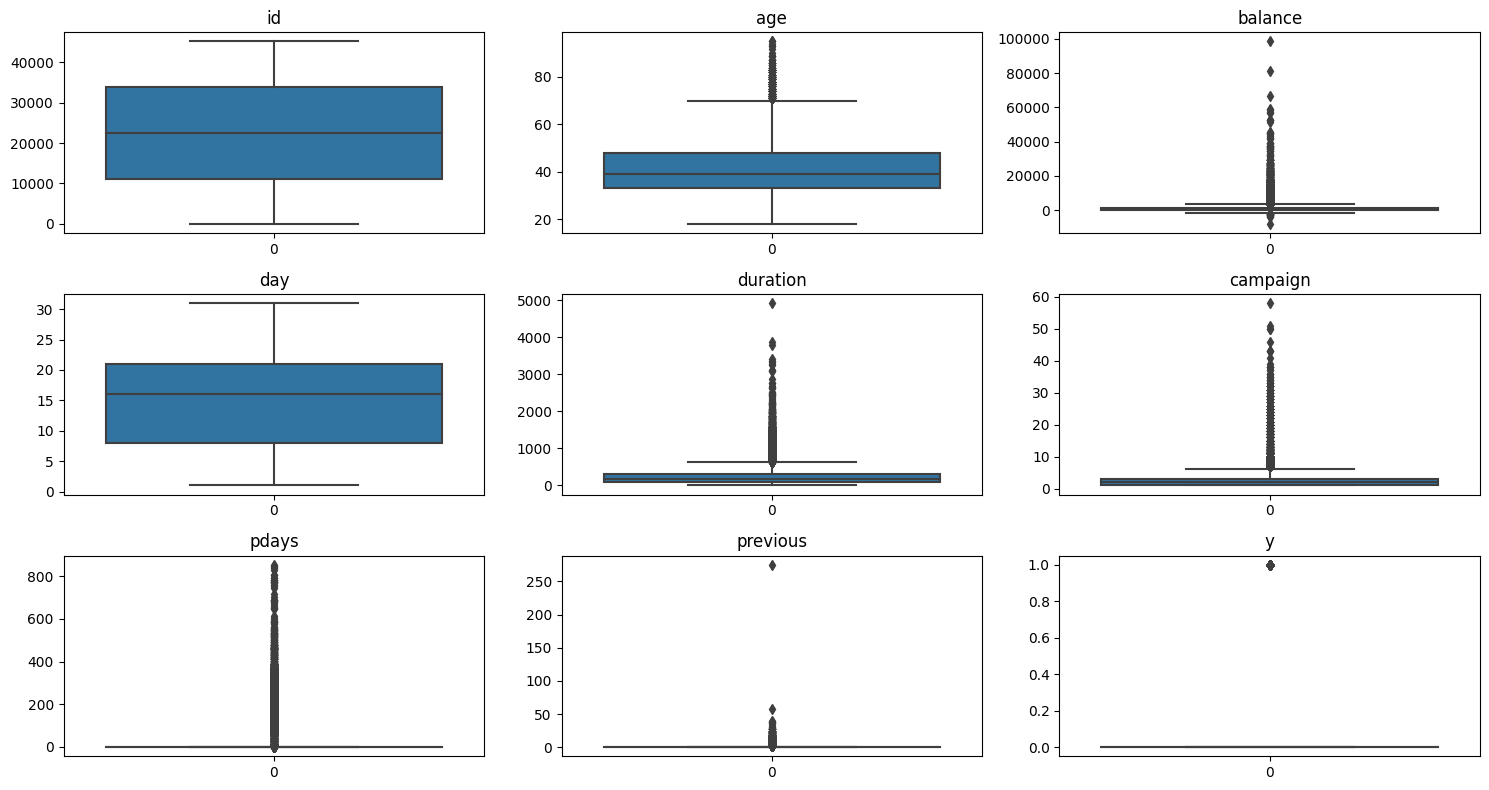

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(15,8))
axes = axes.flatten()

for i, col in enumerate(df.select_dtypes(np.number)):
    sns.boxplot(df[col], ax=axes[i])
    axes[i].tick_params(axis='x')  # miring per subplot
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

<Axes: xlabel='y'>

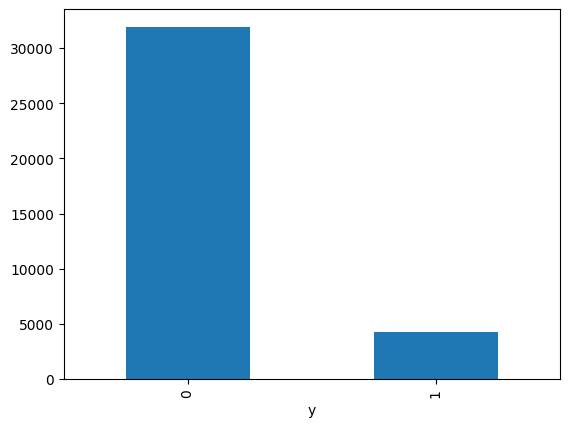

In [9]:
df['y'].value_counts().plot(kind='bar')

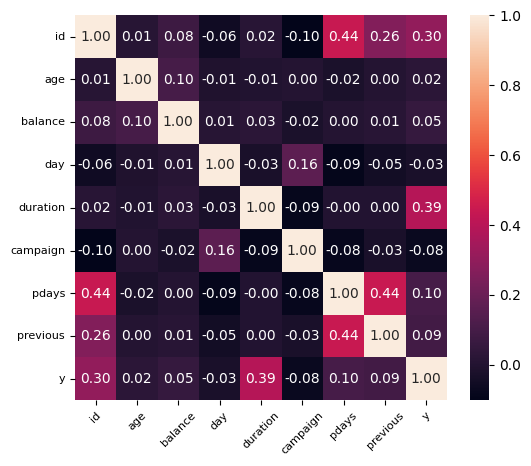

In [10]:
plt.figure(figsize=(6,5))
korelasi = df.select_dtypes(np.number).corr(method='pearson')
sns.heatmap(korelasi, annot=True, fmt='.2f')
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [11]:
df.shape

(36168, 18)

In [12]:
X_train = df.drop('y', axis=1)
y_train = df['y']
X_test = df_test

In [13]:
categorical_features = X_train.select_dtypes(include=['object']).columns
for col in categorical_features:
    X_train[col] = X_train[col].fillna('unknown')
    X_test[col] = X_test[col].fillna('unknown')

preprocess

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [15]:
scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_value
)

xgb_model.fit(X_train_processed, y_train)
predictions = xgb_model.predict(X_test_processed)

In [16]:
submission = pd.DataFrame({
    'id': X_test['id'],
    'y': predictions
})

submission_path = "/kaggle/working/submission.csv"
submission.to_csv(submission_path, index=False)
